In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
auto_mpg_df = pd.read_csv('auto-mpg.csv')
auto_mpg_df.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [2]:
missing_values = auto_mpg_df.isnull().sum()
print("Missing values:\n", missing_values[missing_values >0])

Missing values:
 Series([], dtype: int64)


In [3]:
auto_mpg_df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [4]:
#replacing with mode 
auto_mpg_df['horsepower']= auto_mpg_df['horsepower'].replace('?', np.nan)
auto_mpg_df['horsepower']= pd.to_numeric(auto_mpg_df['horsepower'])
median_horsepower = auto_mpg_df['horsepower'].median()
auto_mpg_df['horsepower'].fillna(median_horsepower, inplace = True)
print("Missing values in 'horsepower' after imputation:", auto_mpg_df['horsepower'].isna().sum())


Missing values in 'horsepower' after imputation: 0


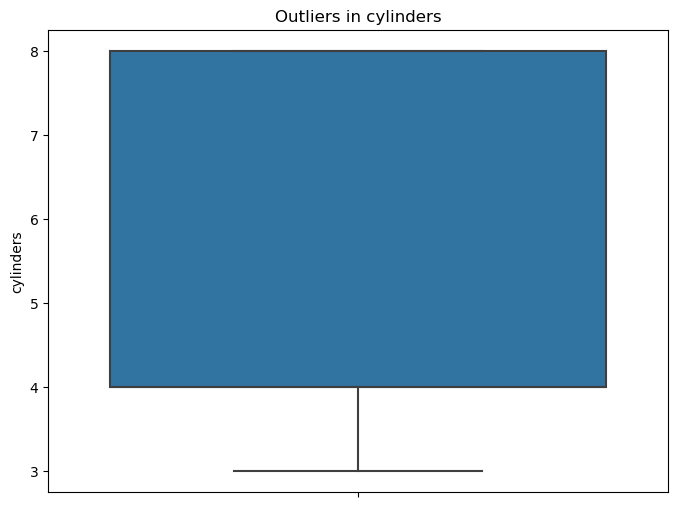

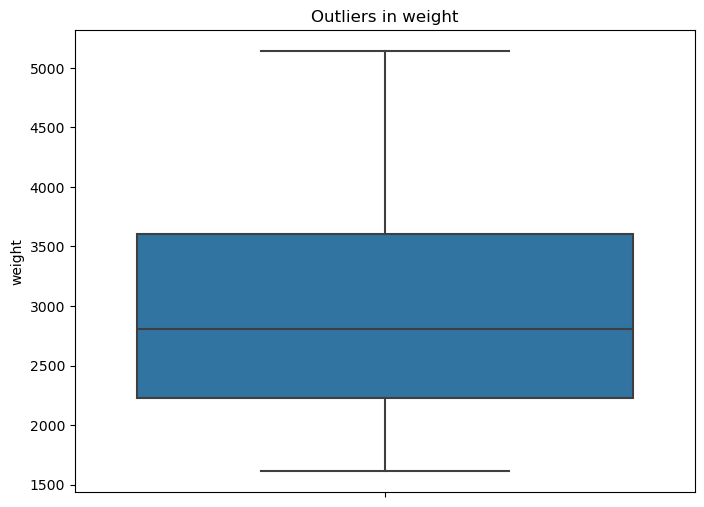

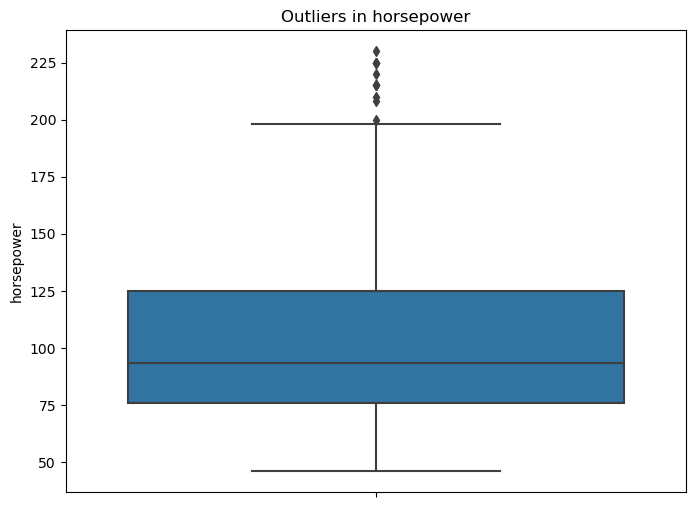

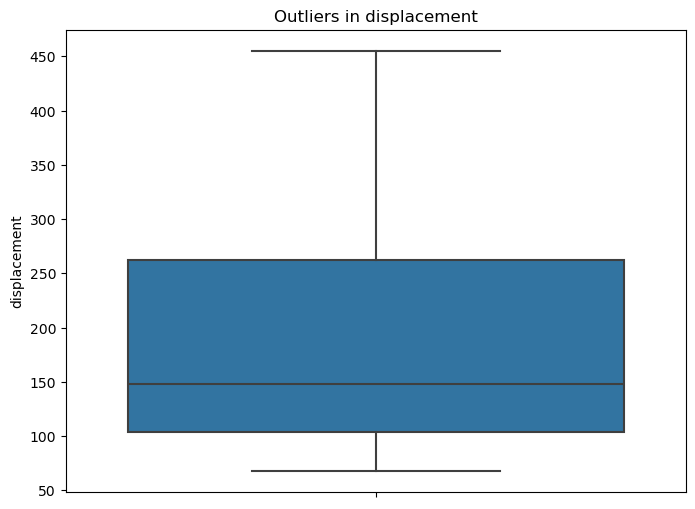

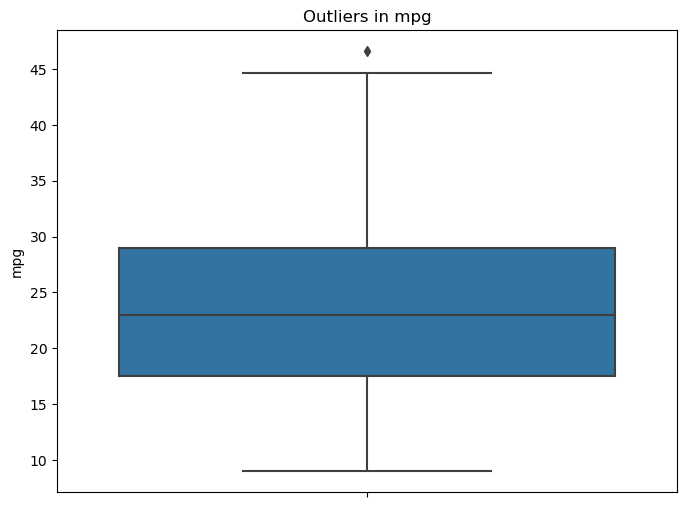

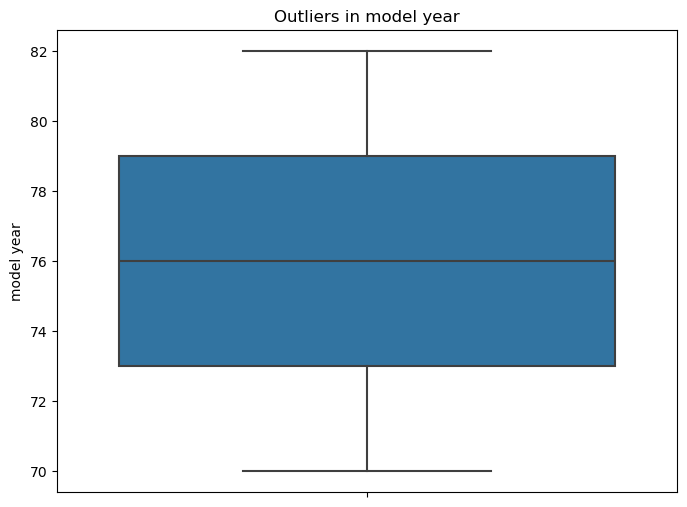

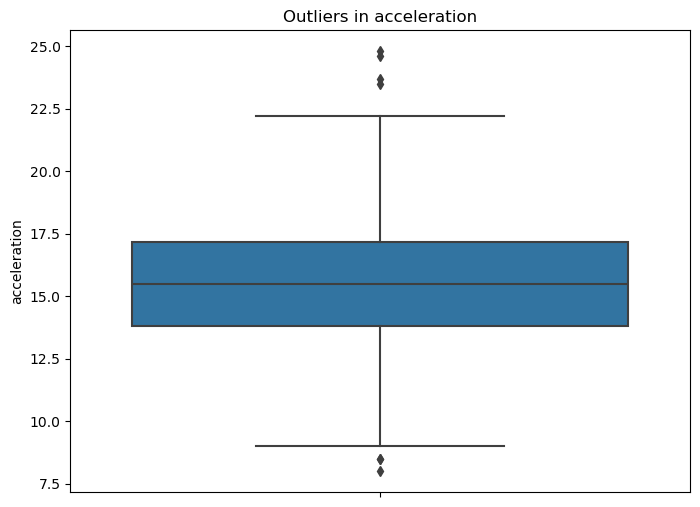

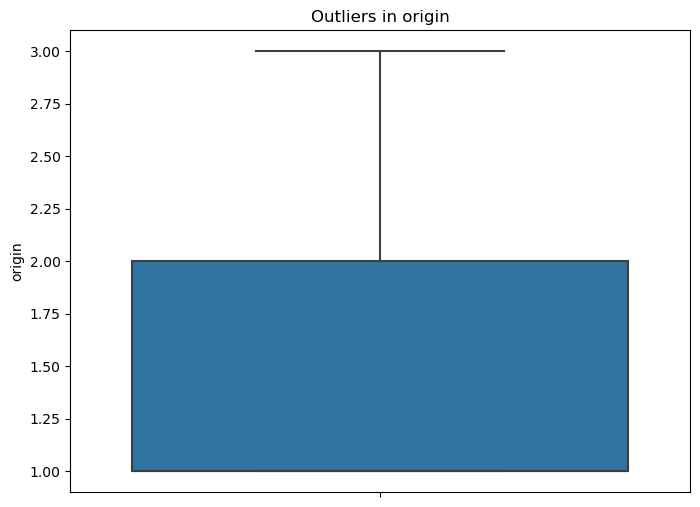

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

columns_box_plot = ['cylinders', 'weight', 'horsepower', 'displacement','mpg','model year','acceleration','origin']
for column in columns_box_plot:
   if pd.api.types.is_numeric_dtype(auto_mpg_df[column]):
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=auto_mpg_df[column])
        plt.title(f'Outliers in {column}')
        plt.show()
   else:
        print(f"Skipping non-numeric column: {column}")

In [6]:
auto_mpg_df['horsepower_numeric'] = pd.to_numeric(auto_mpg_df['horsepower'],errors='coerce')
non_numeric_horsepower_rows = auto_mpg_df[auto_mpg_df['horsepower_numeric'].isna()]
print(non_numeric_horsepower_rows)

Empty DataFrame
Columns: [mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin, car name, horsepower_numeric]
Index: []


C:\Users\jahna\anaconda\jupyter\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


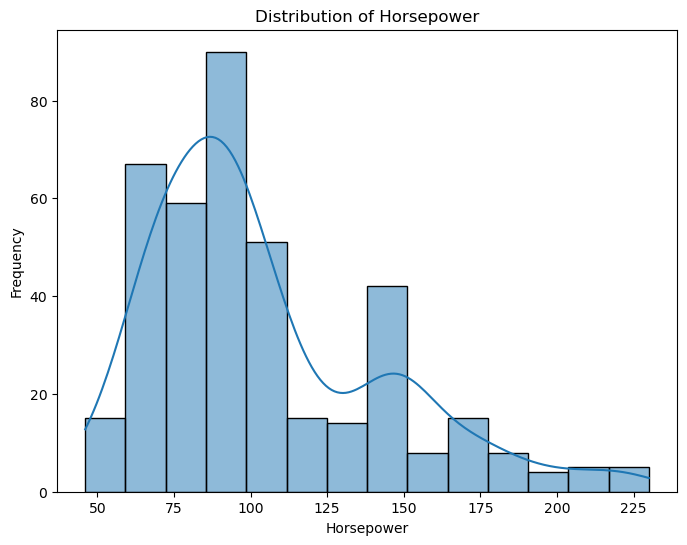

In [7]:
plt.figure(figsize=(8, 6))
sns.histplot(auto_mpg_df['horsepower'].dropna(), kde=True)
plt.title("Distribution of Horsepower")
plt.xlabel("Horsepower")
plt.ylabel("Frequency")
plt.show()

In [8]:
auto_mpg_df['horsepower']= auto_mpg_df['horsepower'].replace('?', np.nan)
auto_mpg_df['horsepower']= pd.to_numeric(auto_mpg_df['horsepower'])
median_horsepower = auto_mpg_df['horsepower'].median()
auto_mpg_df['horsepower'].fillna(median_horsepower, inplace = True)
print("Missing values in 'horsepower' after imputation:", auto_mpg_df['horsepower'].isna().sum())


Missing values in 'horsepower' after imputation: 0


In [9]:
unique_origin_values = auto_mpg_df['origin'].unique()
unique_origin_values

array([1, 3, 2], dtype=int64)

In [10]:
unique_carname_values = auto_mpg_df['car name'].nunique()
unique_carname_values

305

In [11]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.interpolate import UnivariateSpline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR

X = auto_mpg_df.drop(columns=['mpg', 'car name'])
y = auto_mpg_df['mpg']

# Normalizing features using StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Results dictionary to store performance metrics for each model
results = {
    'Regression Tree': {'MSE': [], 'RMSE': [], 'RSE': [], 'RSS': [], 'R^2': []},
    'Ridge Regression': {'MSE': [], 'RMSE': [], 'RSE': [], 'RSS': [], 'R^2': []},
    'Lasso Regression': {'MSE': [], 'RMSE': [], 'RSE': [], 'RSS': [], 'R^2': []},
    'Principal Component Regression (PCR)': {'MSE': [], 'RMSE': [], 'RSE': [], 'RSS': [], 'R^2': []},
    'Regression Splines': {'MSE': [], 'RMSE': [], 'RSE': [], 'RSS': [], 'R^2': []},
    'Support Vector Regression (SVR)': {'MSE': [], 'RMSE': [], 'RSE': [], 'RSS': [], 'R^2': []}
}

num_features = X.shape[1]

# Running the models multiple times to compute average metrics
for _ in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=None)

    # Defining models
    models = {
        'Regression Tree': DecisionTreeRegressor(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Principal Component Regression (PCR)': make_pipeline(PCA(n_components=num_features), LinearRegression()),
        'Regression Splines': make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
        'Support Vector Regression (SVR)': SVR()
    }

    # Fitting models and computing metrics
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        rss = np.sum((y_test - y_pred) ** 2)
        rse = np.sqrt(rss / (len(y_test) - X_test.shape[1] - 1))
        r2 = r2_score(y_test, y_pred)
        
        results[model_name]['MSE'].append(mse)
        results[model_name]['RMSE'].append(rmse)
        results[model_name]['RSE'].append(rse)
        results[model_name]['RSS'].append(rss)
        results[model_name]['R^2'].append(r2)

# Calculating average results
average_results = {model: {metric: np.mean(scores) for metric, scores in metrics.items()} for model, metrics in results.items()}

# Converting results to a DataFrame for better visualization
results_df = pd.DataFrame(average_results).T
results_df


,MSE,RMSE,RSE,RSS,R^2
Regression Tree,14.111579,3.738574,3.887184,1693.389500,0.768768
Ridge Regression,11.459226,3.373260,3.507348,1375.107145,0.815125
Lasso Regression,13.528949,3.657145,3.802518,1623.473857,0.783249
Principal Component Regression (PCR),11.485863,3.377341,3.511591,1378.303590,0.814677
Regression Splines,40.686692,5.994868,6.233167,4882.403027,0.310864
Support Vector Regression (SVR),10.448800,3.211089,3.338731,1253.855946,0.832727


Running GridSearchCV for Ridge Regression...
Ridge Regression - Best Parameters: {'ridge__alpha': 1}
Ridge Regression - Metrics: {'MSE': 9.300951798181787, 'RMSE': 3.049746185862323, 'RSE': 3.1709750905772487, 'RSS': 1116.1142157818144, 'R²': 0.8379381292246572}



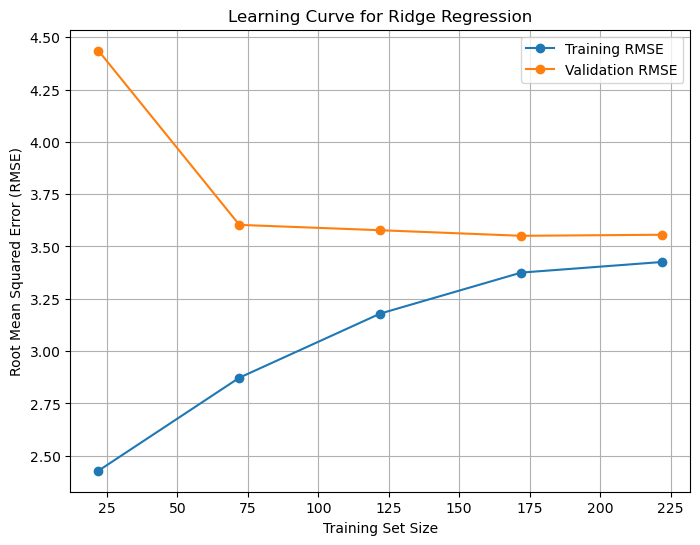

Running GridSearchCV for Lasso Regression...
Lasso Regression - Best Parameters: {'lasso__alpha': 0.1}
Lasso Regression - Metrics: {'MSE': 9.299806487193973, 'RMSE': 3.0495584085558964, 'RSE': 3.170779849030915, 'RSS': 1115.9767784632768, 'R²': 0.8379580853802563}



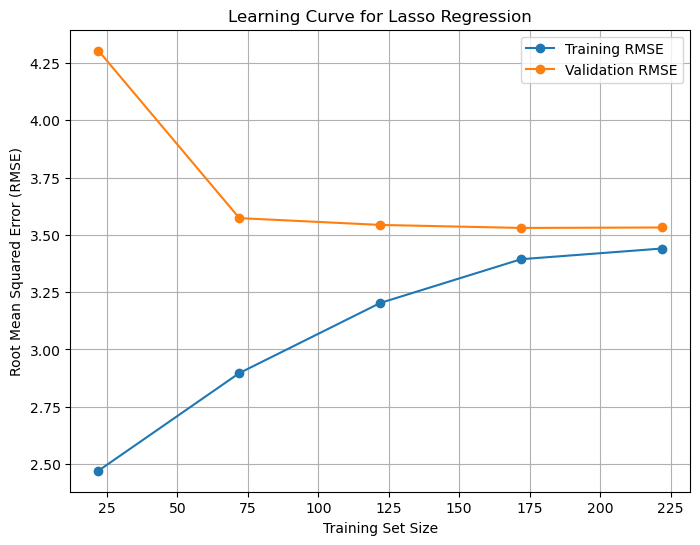

Running GridSearchCV for Principal Component Regression (PCR)...
Principal Component Regression (PCR) - Best Parameters: {'pca__n_components': 8}
Principal Component Regression (PCR) - Metrics: {'MSE': 9.271774044606094, 'RMSE': 3.0449587919389147, 'RSE': 3.165997395400423, 'RSS': 1112.6128853527312, 'R²': 0.8384465289489116}



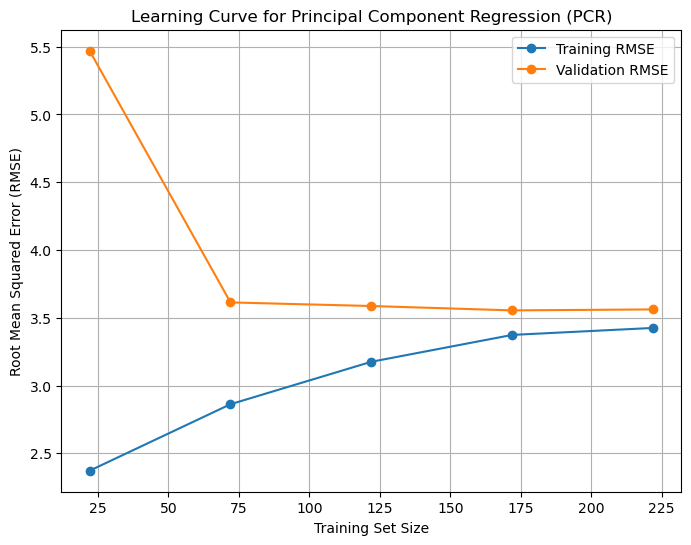

Running GridSearchCV for Regression Splines...
Regression Splines - Best Parameters: {'polynomialfeatures__degree': 2}
Regression Splines - Metrics: {'MSE': 7.204804285035902, 'RMSE': 2.6841766493723735, 'RSE': 2.7908739859485268, 'RSS': 864.5765142043082, 'R²': 0.8744618737588362}



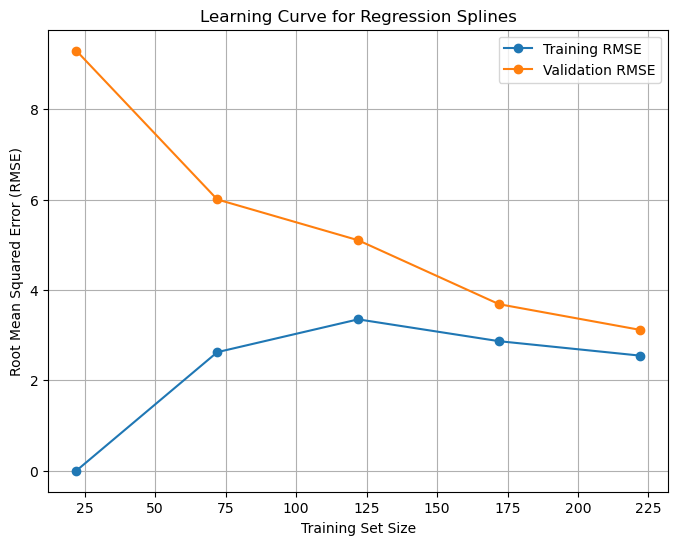

Running GridSearchCV for Regression Tree...
Regression Tree - Best Parameters: {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 10}
Regression Tree - Metrics: {'MSE': 9.269777124367774, 'RMSE': 3.0446308683266965, 'RSE': 3.165656436663996, 'RSS': 1112.3732549241329, 'R²': 0.8384813237351478}



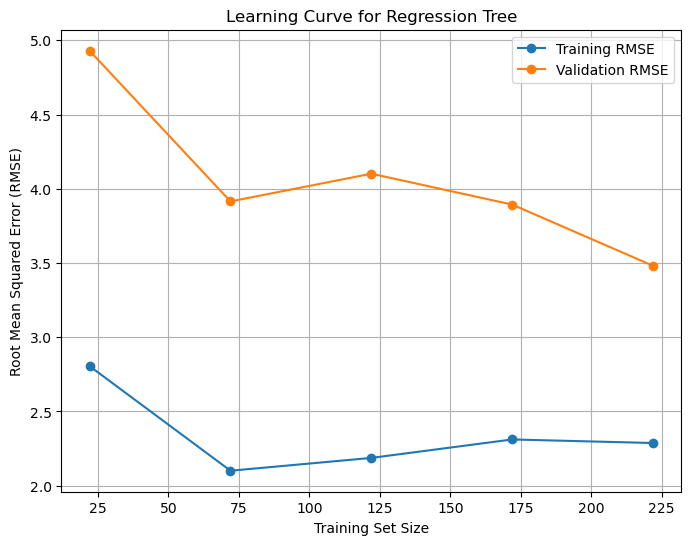

Running GridSearchCV for Support Vector Regression (SVR)...
Support Vector Regression (SVR) - Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.5}
Support Vector Regression (SVR) - Metrics: {'MSE': 4.981207145857248, 'RMSE': 2.231861811550448, 'RSE': 2.3205794117702934, 'RSS': 597.7448575028698, 'R²': 0.9132063291699952}



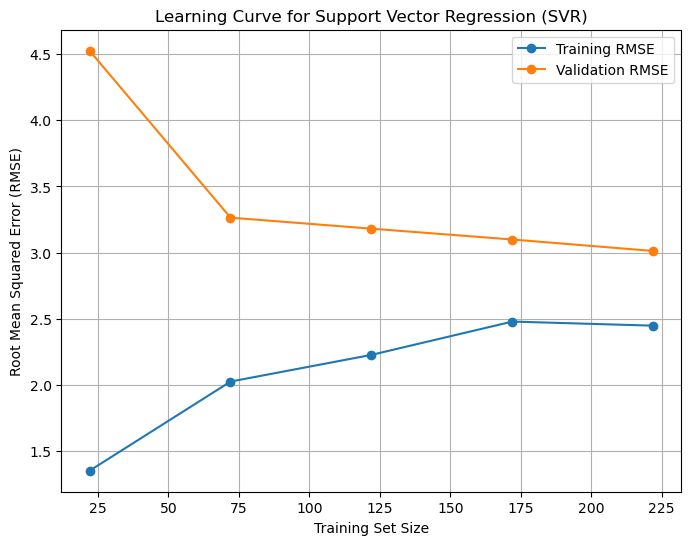


Model Performance Metrics:
                                           MSE      RMSE       RSE  \
Ridge Regression                      9.300952  3.049746  3.170975   
Lasso Regression                      9.299806  3.049558  3.170780   
Principal Component Regression (PCR)  9.271774  3.044959  3.165997   
Regression Splines                    7.204804  2.684177  2.790874   
Regression Tree                       9.269777  3.044631  3.165656   
Support Vector Regression (SVR)       4.981207  2.231862  2.320579   

                                              RSS        R²  
Ridge Regression                      1116.114216  0.837938  
Lasso Regression                      1115.976778  0.837958  
Principal Component Regression (PCR)  1112.612885  0.838447  
Regression Splines                     864.576514  0.874462  
Regression Tree                       1112.373255  0.838481  
Support Vector Regression (SVR)        597.744858  0.913206  

Best Parameters for Each Model:
Ridge Regressi

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Ridge Regression': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]},
    'Lasso Regression': {'lasso__alpha': [0.01, 0.1, 1, 10, 100]},
    'Principal Component Regression (PCR)': {'pca__n_components': [1, 2, 3, 4, X.shape[1]]},
    'Regression Splines': {'polynomialfeatures__degree': [2, 3, 4]},
    'Regression Tree': {
      'decisiontreeregressor__max_depth': [3, 4, 5],
      'decisiontreeregressor__min_samples_split': [10, 15, 20],
      'decisiontreeregressor__min_samples_leaf': [4, 8, 10]
},
    'Support Vector Regression (SVR)': {'svr__C': [0.1, 1, 10], 'svr__epsilon': [0.1, 0.5, 1]}
}



# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, n_features):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    rss = np.sum((y_true - y_pred) ** 2)
    rse = np.sqrt(rss / (len(y_true) - n_features - 1))
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'RSE': rse, 'RSS': rss, 'R²': r2}

# Function to plot learning curves
def plot_learning_curve(model, X, y, model_name, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    test_rmse = np.sqrt(-test_scores.mean(axis=1))

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_rmse, label="Training RMSE", marker='o')
    plt.plot(train_sizes, test_rmse, label="Validation RMSE", marker='o')
    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.legend()
    plt.grid()
    plt.show()

# Dictionary to store results
results = {}
best_parameters = {}

# Iterate over each model and perform GridSearchCV
for model_name, grid_params in param_grids.items():
    print(f"Running GridSearchCV for {model_name}...")
    
    # Define the model pipeline
    if model_name == 'Principal Component Regression (PCR)':
        model = make_pipeline(StandardScaler(), PCA(), LinearRegression())
    elif model_name == 'Regression Splines':
        model = make_pipeline(PolynomialFeatures(), LinearRegression())
    elif model_name == 'Ridge Regression':
        model = make_pipeline(StandardScaler(), Ridge(max_iter=5000))
    elif model_name == 'Lasso Regression':
        model = make_pipeline(StandardScaler(), Lasso(max_iter=5000))
    elif model_name == 'Regression Tree':
        model = make_pipeline(StandardScaler(), DecisionTreeRegressor())
    elif model_name == 'Support Vector Regression (SVR)':
        model = make_pipeline(StandardScaler(), SVR())

    # Perform GridSearchCV
    grid_search = GridSearchCV(model, grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    # Store the best parameters
    best_parameters[model_name] = grid_search.best_params_
    
    # Predict on the test set using the best estimator
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    
    # Calculate performance metrics
    metrics = calculate_metrics(y_test, y_pred, X_test_scaled.shape[1])
    results[model_name] = metrics

    print(f"{model_name} - Best Parameters: {grid_search.best_params_}")
    print(f"{model_name} - Metrics: {metrics}\n")

    # Plot learning curve for the best model
    plot_learning_curve(best_model, X_train_scaled, y_train, model_name)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print("\nModel Performance Metrics:")
print(results_df)

# Display best parameters for each model
print("\nBest Parameters for Each Model:")
for model_name, params in best_parameters.items():
    print(f"{model_name}: {params}")


In [18]:
results_df

,MSE,RMSE,RSE,RSS,R²
Ridge Regression,9.300952,3.049746,3.170975,1116.114216,0.837938
Lasso Regression,9.299806,3.049558,3.170780,1115.976778,0.837958
Principal Component Regression (PCR),9.271774,3.044959,3.165997,1112.612885,0.838447
Regression Splines,7.204804,2.684177,2.790874,864.576514,0.874462
Regression Tree,9.269777,3.044631,3.165656,1112.373255,0.838481
Support Vector Regression (SVR),4.981207,2.231862,2.320579,597.744858,0.913206
